### パターン２の位置情報を予測する
<img src="./RSSI取得実験図/pattern2.png" alt="パターン2">

##### パターン２では発信機の場所は常に固定であるため受信したデータから発信機の番号を予測することで位置情報の予測とする。

In [1]:
# 必要なライブラリの読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
plt.rcParams["figure.figsize"] = [20, 12] # グラフのサイズを指定
plt.rcParams['font.size'] = 20 #フォントサイズを設定 default : 12
plt.rcParams['xtick.labelsize'] = 15 # 横軸のフォントサイズ
plt.rcParams['ytick.labelsize'] = 15 # 縦軸のフォントサイズ

In [2]:
# データセット読み込み (pattern2 = p2)
p2 = pd.read_csv("./取得データセット/pattern2.csv")
p2.columns = ["UUIDs","Major","Minor","Accuracy","Proximity","TxPower","RSSI","device_name","timestamp"]

In [3]:
df = p2
# 生データ
df.head()

,UUIDs,Major,Minor,Accuracy,Proximity,TxPower,RSSI,device_name,timestamp
0,10000000aaaa41441111110000000000,2,38,1.210637,near,-78,-82,rasp2,2017/10/03 15:39:27
1,40000000aaaa41441111110000000000,2,35,1.774360,near,-78,-90,rasp2,2017/10/03 15:39:27
2,20000000aaaa41441111110000000000,2,40,1.397251,near,-78,-85,rasp2,2017/10/03 15:39:27
3,10000000aaaa41441111110000000000,2,38,1.465642,near,-78,-86,rasp2,2017/10/03 15:39:27
4,10000000aaaa41441111110000000000,2,38,1.210637,near,-78,-82,rasp2,2017/10/03 15:39:27


#### 各ラベルの情報：  
UUIDs,Major,Minor : 発信機の特定に使われる  
Accuracy : 推定距離のばらつきを示す  
Proximity : 1M地点でビーコンが発する信号の強さ  
RSSI : 電波強度  
device_name : 受信機名  
timestamp : 受信時の時間を記録

### 発信機情報とRSSIを用いて位置情報推定を行う

##### 前処理 :

In [4]:
#　オブジェクト型の目的変数を数値情報に変換

# UUIDsを変換
import sklearn.preprocessing as sp
le = sp.LabelEncoder()
le.fit(df[df.columns[0]].unique())
df["locate"] = le.transform(df[df.columns[0]]) + 1

# timestampを変換
le = sp.LabelEncoder()
le.fit(df[df.columns[8]].unique())
df["date_label"] = le.transform(df[df.columns[8]])

# 発信機ごとに種類分け
df_1 = df[df['UUIDs']  == "10000000aaaa41441111110000000000"]
df_2 = df[df['UUIDs']  == "20000000aaaa41441111110000000000"]
df_3 = df[df['UUIDs']  == "30000000aaaa41441111110000000000"]
df_4 = df[df['UUIDs']  == "40000000aaaa41441111110000000000"]

#### XGBoostを用いて学習

In [5]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

# 検定を行うデータを定義
X = np.array(df[["RSSI","date_label"]])
y = np.array(df["locate"])
kf = KFold(n_splits=5,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

精度 : 0.766256157635
精度 : 0.760344827586
精度 : 0.753880266075
精度 : 0.751662971175
精度 : 0.761763981276


In [6]:
# 訓練用データとテストデータを用意
import sklearn.cross_validation as crv
X_train, X_test, y_train, y_test = crv.train_test_split(df[["RSSI","date_label"]], np.array(df["locate"]), test_size=0.3)

# オブジェクトを作成し学習
mod = xgb.XGBClassifier()
mod.fit(X_train,y_train)

# オープンテスト
pred = mod.predict(X_test)
open_score = accuracy_score(pred,y_test)
print("精度 : %s" % open_score)

/Users/art/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


精度 : 0.758620689655


### 反射波の影響を取り除いて学習

#### 受信機ごとのRSSI値に対してクラスタリングを行い反射波との分布をみる

非階層的クラスタリング  
非階層的クラスタリング (例: K-Means 法) では、決められたクラスタ数にしたがって、近い属性のデータをグループ化します。  
<img src="./RSSI取得実験図/kmeans.png" alt="パターン2">

### 全データに対してクラスタ数を8としてクラスタリング 

In [7]:
# KMeansライブラリをインポート
from sklearn.cluster import KMeans

# クラスタ数
N_CLUSTERS = 8

# RSSIとlocate情報を使用してクラスタリング
pred = KMeans(n_clusters=N_CLUSTERS).fit_predict(df[["RSSI","locate"]])

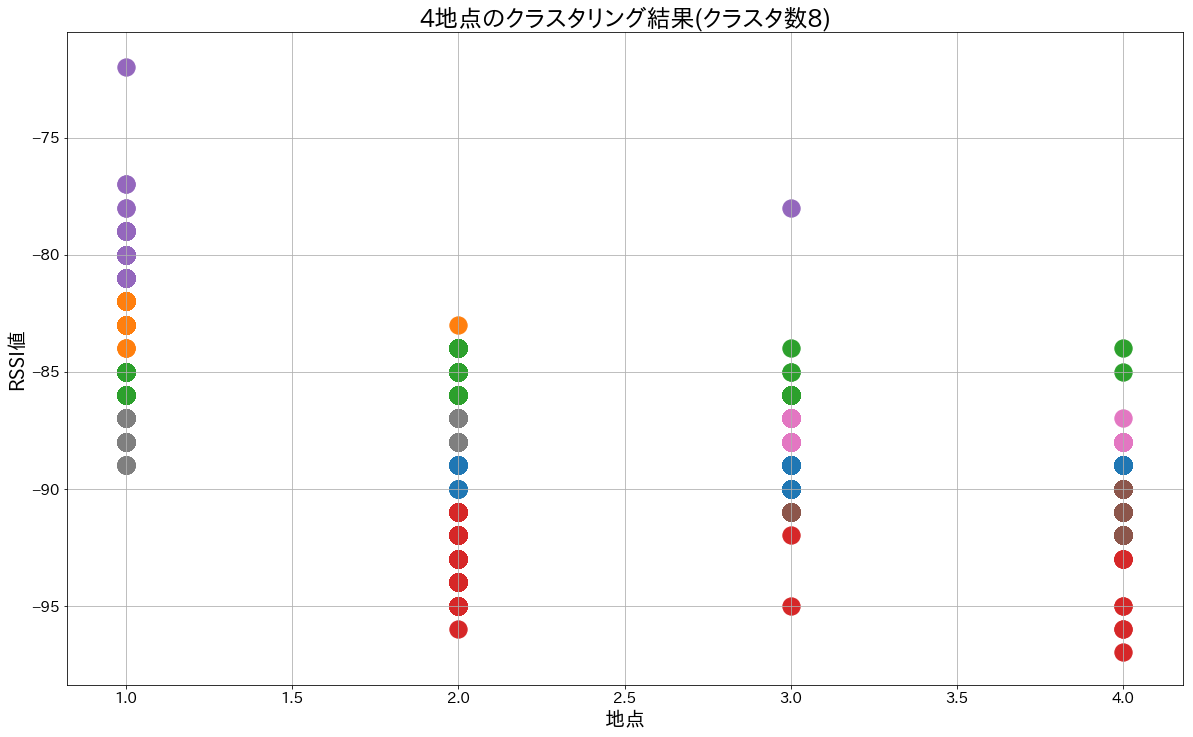

In [8]:
for i in range(N_CLUSTERS):
    labels = df[pred == i]
    plt.scatter(labels["locate"], labels["RSSI"],s=300)
plt.title("4地点のクラスタリング結果(クラスタ数8)")
plt.xlabel("地点")
plt.ylabel("RSSI値")
plt.grid(True)
plt.show()

##### 各地点ごとにクラスタリングした結果をみる

/Users/art/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/art/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


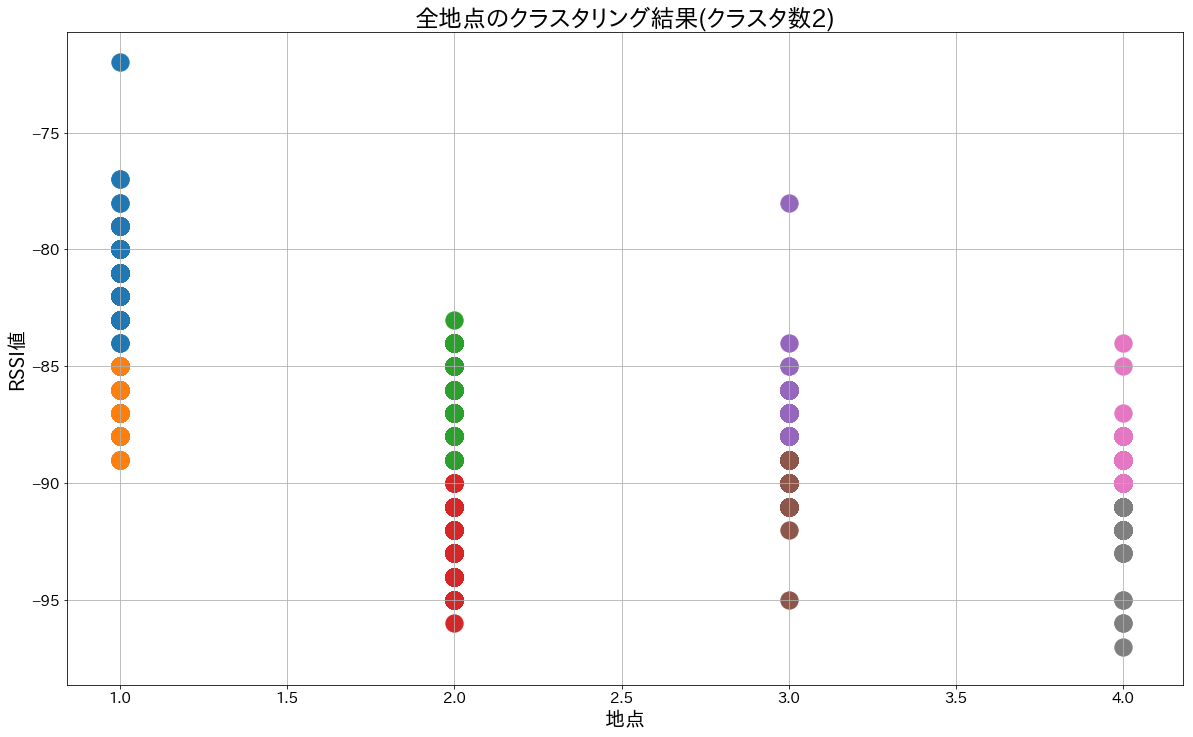

In [9]:
# クラスタ数
N_CLUSTERS = 2

# RSSIとlocate情報を使用してクラスタリング
pred_1 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_1[["RSSI","locate"]])
df_1.loc[:,("pred")] = pred_1
for i in range(2):
    labels1 = df_1[pred_1 == i]
    plt.scatter(labels1["locate"],labels1["RSSI"],s=300)

pred_2 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_2[["RSSI","locate"]])
df_2.loc[:,("pred")] = pred_2
for i in range(2):
    labels2 = df_2[pred_2 == i]
    plt.scatter(labels2["locate"],labels2["RSSI"],s=300)
    
pred_3 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_3[["RSSI","locate"]])
df_3.loc[:,("pred")] = pred_3
for i in range(2):
    labels3 = df_3[pred_3 == i]
    plt.scatter(labels3["locate"],labels3["RSSI"],s=300)

pred_4 = KMeans(n_clusters=N_CLUSTERS).fit_predict(df_4[["RSSI","locate"]])
df_4.loc[:,("pred")] = pred_4
for i in range(2):
    labels4 = df_4[pred_4 == i]
    plt.scatter(labels4["locate"],labels4["RSSI"],s=300)
    
# データフレームの結合
train = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)

plt.title("全地点のクラスタリング結果(クラスタ数2)")
plt.xlabel("地点")
plt.ylabel("RSSI値")
plt.grid(True)
plt.show()

##### クラスタリング結果を用いて再度精度を検証する

In [10]:
from sklearn.model_selection import KFold

# 検定を行うデータを定義
X = np.array(train[["RSSI","date_label","pred"]])
y = np.array(train["locate"])
kf = KFold(n_splits=5,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

精度 : 0.883497536946
精度 : 0.876354679803
精度 : 0.878295146588
精度 : 0.882237004188
精度 : 0.879034244888


In [11]:
# 学習用にデータを分割
X_train, X_test, y_train, y_test = crv.train_test_split(train[["RSSI","date_label","pred"]], np.array(train["locate"]), test_size=0.3)

# オブジェクトを作成し学習
mod = xgb.XGBClassifier()
mod.fit(X_train,y_train)

# オープンテスト
pred = mod.predict(X_test)
open_score = accuracy_score(pred,y_test)
print("精度 : %s" % open_score)

精度 : 0.874548440066


少し精度があがった

####  クラスタリングの精度を向上させる

地点1クラスタ間の重心距離 : 4.95185836106
地点2クラスタ間の重心距離 : 6.40956406231
地点3クラスタ間の重心距離 : 1.86992276017
地点4クラスタ間の重心距離 : 1.50527674975


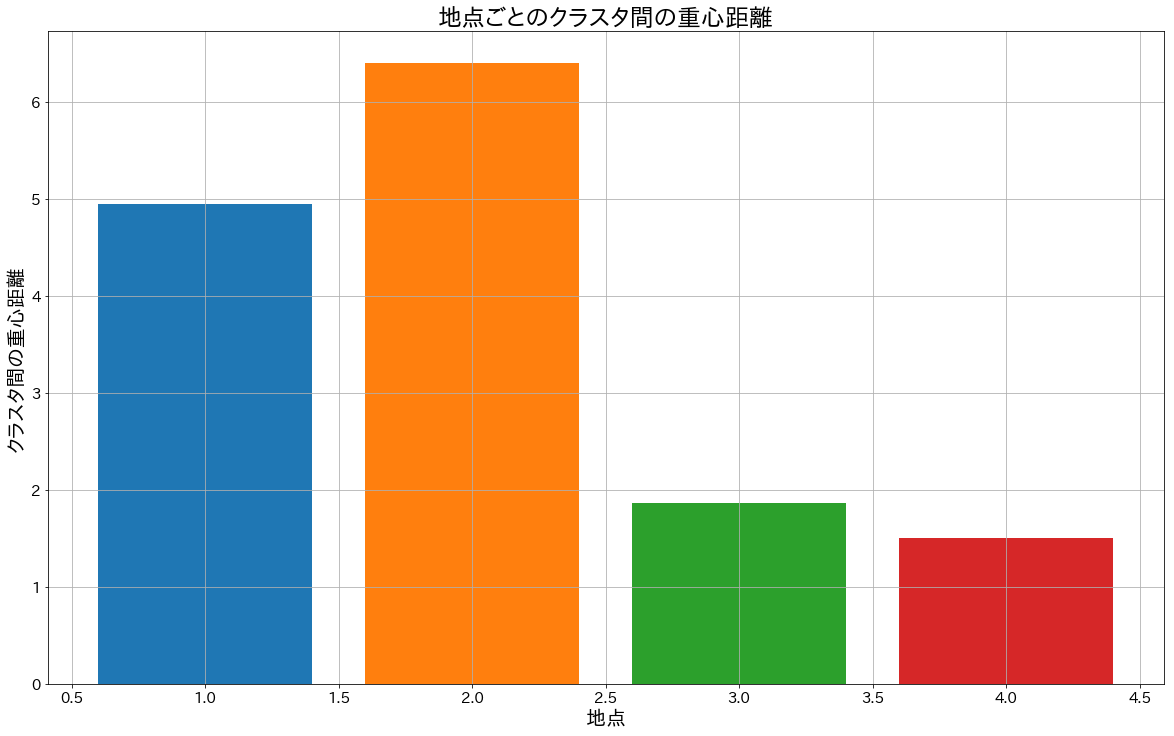

In [12]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

# RSSIとlocate情報を使用してクラスタリング
X = df_1[["RSSI","locate"]]
clster = KMeans(n_clusters=N_CLUSTERS).fit(X)
center = clster.cluster_centers_
distance = np.linalg.norm(center[0]-center[1])
# 重点間の距離を計算する
print("地点1クラスタ間の重心距離 : %s" % distance)
plt.bar(1,distance)

# RSSIとlocate情報を使用してクラスタリング
X = df_2[["RSSI","locate"]]
clster = KMeans(n_clusters=N_CLUSTERS).fit(X)
center = clster.cluster_centers_
distance = np.linalg.norm(center[0]-center[1])
# 重点間の距離を計算する
print("地点2クラスタ間の重心距離 : %s" % distance)
plt.bar(2,distance)

# RSSIとlocate情報を使用してクラスタリング
X = df_3[["RSSI","locate"]]
clster = KMeans(n_clusters=N_CLUSTERS).fit(X)
center = clster.cluster_centers_
distance = np.linalg.norm(center[0]-center[1])
# 重点間の距離を計算する
print("地点3クラスタ間の重心距離 : %s" % distance)
plt.bar(3,distance)

# RSSIとlocate情報を使用してクラスタリング
X = df_4[["RSSI","locate"]]
clster = KMeans(n_clusters=N_CLUSTERS).fit(X)
center = clster.cluster_centers_
distance = np.linalg.norm(center[0]-center[1])
# 重点間の距離を計算する
print("地点4クラスタ間の重心距離 : %s" % distance)
plt.bar(4,distance)

plt.title("地点ごとのクラスタ間の重心距離")
plt.xlabel("地点")
plt.ylabel("クラスタ間の重心距離")
plt.grid(True)
plt.show()

クラスタ間の距離が低いと入射波のみを観測しているケースになると考えられる。  
そのため、今回は２点間の重心距離が2以下の場合は入射波のみを計測したと仮定して学習を行う。  

####  クラスタ数を考慮して再度クラスタリングを行う

/Users/art/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


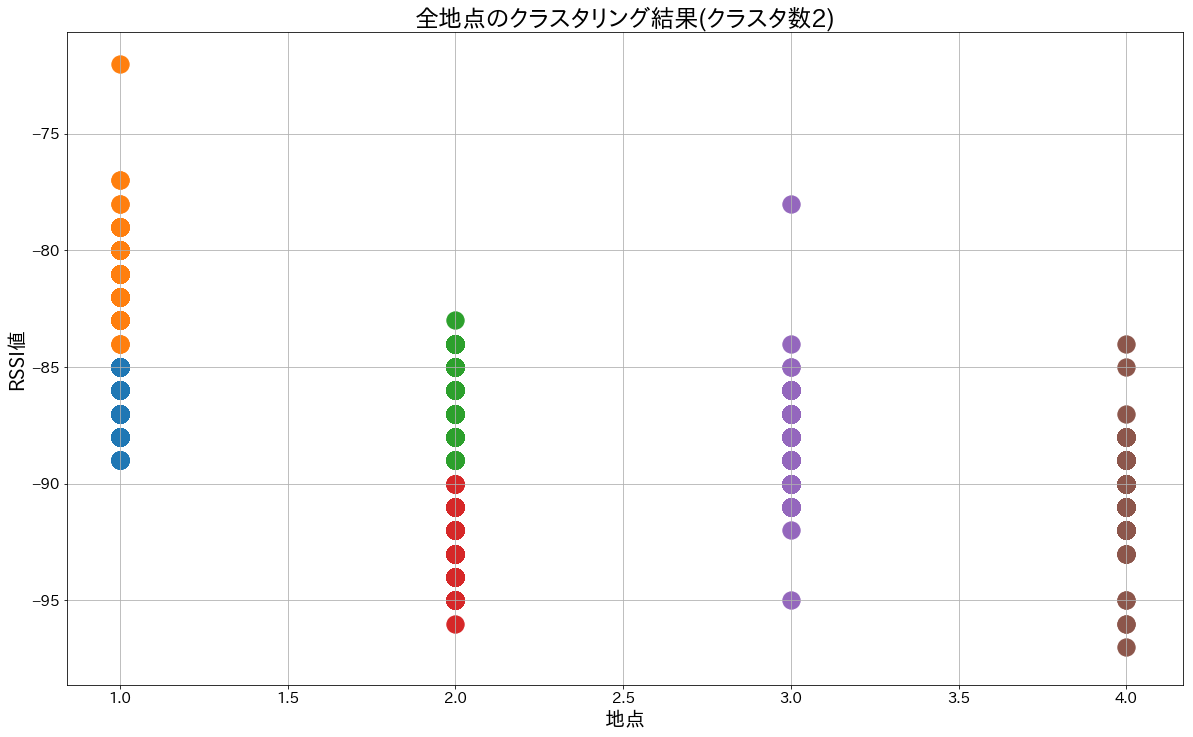

In [13]:
# クラスタ数
N_CLUSTERS = 2

# 地点1をクラスタリング
X = df_1[["RSSI","locate"]]
clster = KMeans(n_clusters=N_CLUSTERS).fit(X)
center = clster.cluster_centers_
# クラスタの重心間の距離を測る
distance = np.linalg.norm(center[0]-center[1])

if distance >= 2 :
    df_1.loc[:,("pred")] = clster.labels_
    for i in range(2):
        labels1 = df_1[clster.labels_ == i]
        plt.scatter(labels1["locate"],labels1["RSSI"],s=300)
else : 
    df_1.loc[:,("pred")] = 0 
    plt.scatter(df_1["locate"],df_1["RSSI"],s=300)
    
    
# 地点2をクラスタリング
X = df_2[["RSSI","locate"]]
clster = KMeans(n_clusters=N_CLUSTERS).fit(X)
center = clster.cluster_centers_
# クラスタの重心間の距離を測る
distance = np.linalg.norm(center[0]-center[1])

if distance >= 2 :
    df_2.loc[:,("pred")] = clster.labels_
    for i in range(2):
        labels2 = df_2[clster.labels_ == i]
        plt.scatter(labels2["locate"],labels2["RSSI"],s=300)
else : 
    df_2.loc[:,("pred")] = 0 
    plt.scatter(df_2["locate"],df_2["RSSI"],s=300)
    

# 地点3をクラスタリング
X = df_3[["RSSI","locate"]]
clster = KMeans(n_clusters=N_CLUSTERS).fit(X)
center = clster.cluster_centers_
# クラスタの重心間の距離を測る
distance = np.linalg.norm(center[0]-center[1])

if distance >= 2 :
    df_3.loc[:,("pred")] = clster.labels_
    for i in range(2):
        labels3 = df_3[clster.labels_ == i]
        plt.scatter(labels3["locate"],labels3["RSSI"],s=300)
else : 
    df_3.loc[:,("pred")] = 0 
    plt.scatter(df_3["locate"],df_3["RSSI"],s=300)
    

# 地点4をクラスタリング
X = df_4[["RSSI","locate"]]
clster = KMeans(n_clusters=N_CLUSTERS).fit(X)
center = clster.cluster_centers_
# クラスタの重心間の距離を測る
distance = np.linalg.norm(center[0]-center[1])

if distance >= 2 :
    df_4.loc[:,("pred")] = clster.labels_
    for i in range(2):
        labels4 = df_4[clster.labels_ == i]
        plt.scatter(labels4["locate"],labels4["RSSI"],s=300)
else : 
    df_4.loc[:,("pred")] = 0 
    plt.scatter(df_4["locate"],df_4["RSSI"],s=300)
    
# データフレームの結合
train = pd.concat([df_1,df_2,df_3,df_4],ignore_index=True)

plt.title("全地点のクラスタリング結果(クラスタ数2)")
plt.xlabel("地点")
plt.ylabel("RSSI値")
plt.grid(True)
plt.show()

In [14]:
# データフレームを確認
train.head()

,UUIDs,Major,Minor,Accuracy,Proximity,TxPower,RSSI,device_name,timestamp,locate,date_label,pred
0,10000000aaaa41441111110000000000,2,38,1.210637,near,-78,-82,rasp2,2017/10/03 15:39:27,1,0,1
1,10000000aaaa41441111110000000000,2,38,1.465642,near,-78,-86,rasp2,2017/10/03 15:39:27,1,0,0
2,10000000aaaa41441111110000000000,2,38,1.210637,near,-78,-82,rasp2,2017/10/03 15:39:27,1,0,1
3,10000000aaaa41441111110000000000,2,38,1.210637,near,-78,-82,rasp2,2017/10/03 15:39:28,1,1,1
4,10000000aaaa41441111110000000000,2,38,1.210637,near,-78,-82,rasp2,2017/10/03 15:39:28,1,1,1


####  再度予測を行い精度をみる

In [16]:
from sklearn.model_selection import KFold

# 検定を行うデータを定義
X = np.array(train[["RSSI","date_label","pred"]])
y = np.array(train["locate"])
kf = KFold(n_splits=5,shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # オブジェクトを作成し学習
    mod = xgb.XGBClassifier()
    clf = mod.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print("精度 : %s" % score)

精度 : 0.767733990148
精度 : 0.789901477833
精度 : 0.763242177876
精度 : 0.769154964277
精度 : 0.767923133777


精度が落ちた